# The aim of this section is to find how we will asses our results and set a baseline 

In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from useful import read_dataset

train_data, test_data, test_rul = read_dataset('FD001')
test_rul

array([112.,  98.,  69.,  82.,  91.,  93.,  91.,  95., 111.,  96.,  97.,
       124.,  95., 107.,  83.,  84.,  50.,  28.,  87.,  16.,  57., 111.,
       113.,  20., 145., 119.,  66.,  97.,  90., 115.,   8.,  48., 106.,
         7.,  11.,  19.,  21.,  50., 142.,  28.,  18.,  10.,  59., 109.,
       114.,  47., 135.,  92.,  21.,  79., 114.,  29.,  26.,  97., 137.,
        15., 103.,  37., 114., 100.,  21.,  54.,  72.,  28., 128.,  14.,
        77.,   8., 121.,  94., 118.,  50., 131., 126., 113.,  10.,  34.,
       107.,  63.,  90.,   8.,   9., 137.,  58., 118.,  89., 116., 115.,
       136.,  28.,  38.,  20.,  85.,  55., 128., 137.,  82.,  59., 117.,
        20.])

# GOAL : Predict RUL 

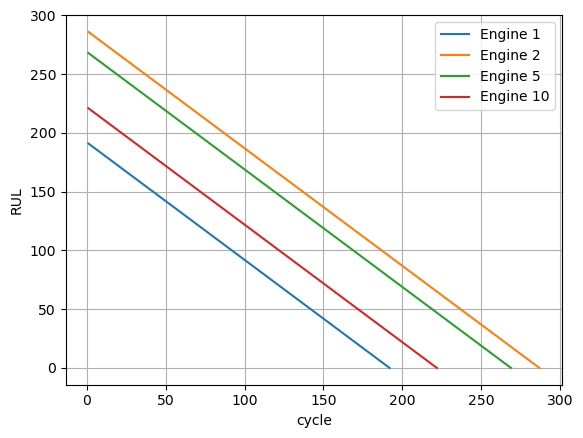

In [16]:
from useful import calculate_RUL


train_data['rul'] = calculate_RUL(train_data)

for _unit in [1, 2, 5, 10]:
    plt.plot(
        train_data[train_data['unit'] == _unit]['time_cycles'], 
        train_data[train_data['unit'] == _unit]['rul'], 
        label=f'Engine {_unit}'
    )
plt.legend()
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()

In most of the papers related to this problem, maximum value of RUL is being **limited to some constant value**. And the motivation is that a degradatation process will be only noticeable in the data after a unit has operated for some time. You can read more about this in this paper - https://www.researchgate.net/publication/224358896_Recurrent_neural_networks_for_remaining_useful_life_estimation.

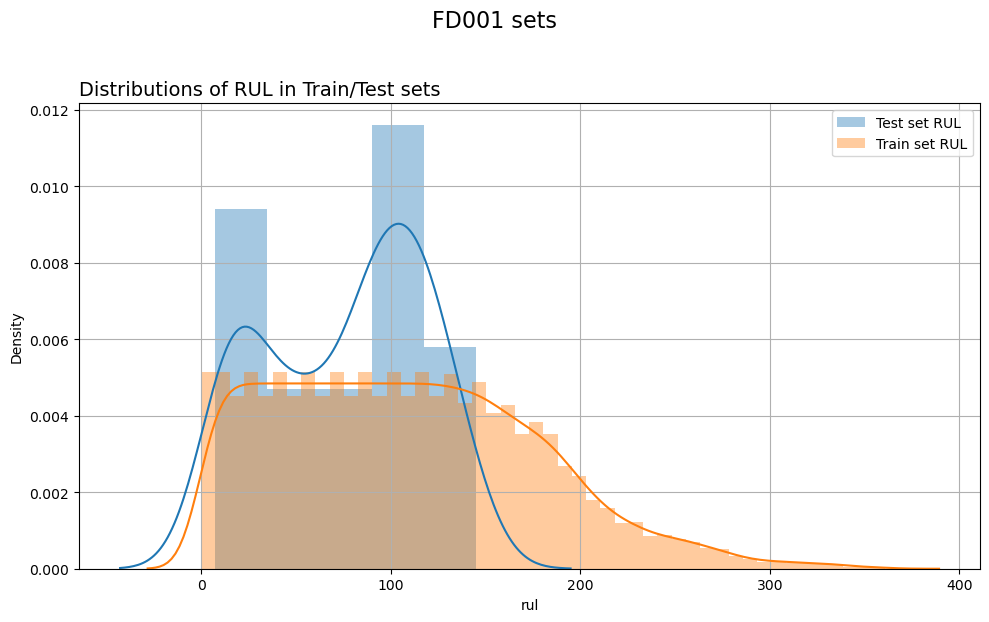

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('FD001 sets', fontsize=16, y=1.03) 
ax.set_title('Distributions of RUL in Train/Test sets', loc='left', size=14)
sns.distplot(test_rul, label='Test set RUL')
sns.distplot(train_data['rul'], label='Train set RUL')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [21]:
RUL_UPPER_THRESHOLD = 135

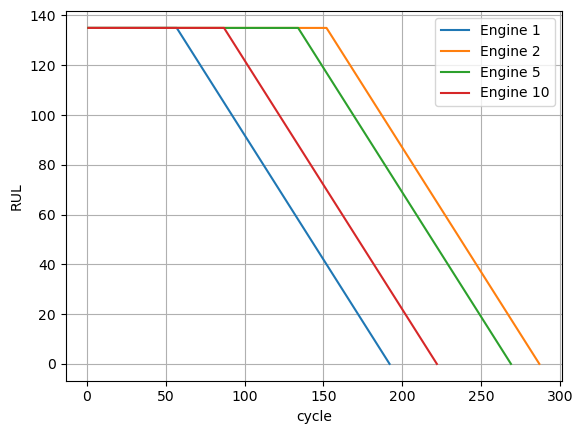

In [22]:
train_data['rul'] = calculate_RUL(train_data, upper_threshold=RUL_UPPER_THRESHOLD)

for _unit in [1, 2, 5, 10]:
    plt.plot(
        train_data[train_data['unit'] == _unit]['time_cycles'], 
        train_data[train_data['unit'] == _unit]['rul'], 
        label=f'Engine {_unit}'
    )
plt.legend()
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()


Let's take a look on the RUL distribution on our different sets ( TRAIN and TEST )

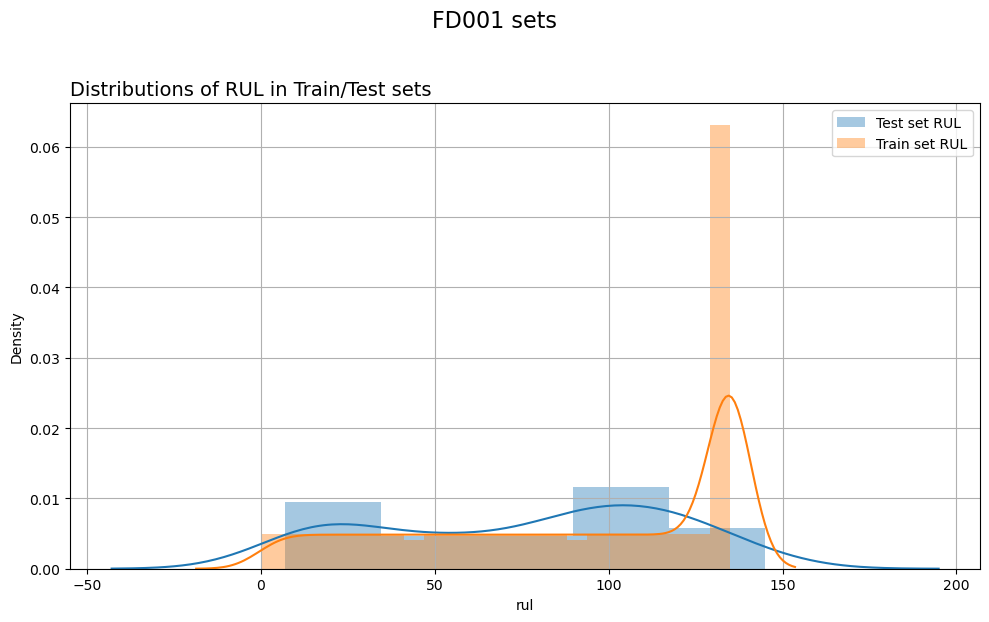

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('FD001 sets', fontsize=16, y=1.03) 
ax.set_title('Distributions of RUL in Train/Test sets', loc='left', size=14)
sns.distplot(test_rul, label='Test set RUL')
sns.distplot(train_data['rul'], label='Train set RUL')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()


# Evaluation Metrics

We are solving a Regression problem here and let's list and discuss the metrics we can use to evaluate the models for estimating Remaining Useful Life:

1. **RMSE** - Root Mean Squared Error - one of the standard metrics for regression, it's a squared root of averaged squared difference between actual and predicted values. An important characteristic of RMSE is that it penalizes larger errors more. 

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}} $$

2. **MAE** - Mean Absolute Error - an average of absolute difference between actual and predicted values. MAE uses the same scale as the data and it's more robust to outliers.

$$ MAE = \frac{1}{n} \sum_{i=1}^{n}{ |y_i - \hat{y_i}| } $$

3. **MAPE** - Mean Absolute Percentage Error - average ratio of error over actual value, it measures the size of error as a percentage. **NOTE that this metric is not defined for $y=0$**. Also, if the actual values are very small, MAPE can be very high because of that. 
Another interesing characteristic of this metric is that **it's biased towards predictions which are lower than the actual values**. MAPE score will be lower for a prediction lower than the actual value, but it will be higher for a prediction which is higher than the actual value by the same amount, e.g. $ y=1, \hat{y}=2$, then $ MAPE = 100\% $, but when $ y=2, \hat{y}=1 $, then $MAPE=50\%$. 

$$ MAPE = 100 * \frac{1}{n} \sum_{i=1}^{n}{ |\frac{y_i - \hat{y_i}}{y_i}| } $$


4. **Custom Score** - this score is being used in most of the papers about estimating Remaining Useful Life for the turbofan data we use here, provided in Saxena et al. [1]. 

$$ SCORE = \sum_{i=1}^{n}{(e^{-\frac{(y_i - \hat{y_i})}{w}} - 1 ) }, $$

where $ w = 10 $, if $\hat{y} \geq y $
and $ w = 13 $, if $\hat{y} \lt y $

**NOTE that since this metric is a SUM, it cannot be compared across datasets of a different size!** It will be larger for a higher $n$. 

This scoring function assigns a **higher penalty when the Predicted RUL is higher than the true RUL** - please, see the figure below. The motivation for this is that late predictions are potentially more costly - predicting end of engine's life after it actually ended can cause much more problems than predicting it too early. 


[1] A. Saxena, K. Goebel, D. Simon, N. Eklund
Damage propagation modeling for aircraft engine run-to-failure simulation
2008 International Conference on Prognostics and Health Management, IEEE (2008), pp. 1-9


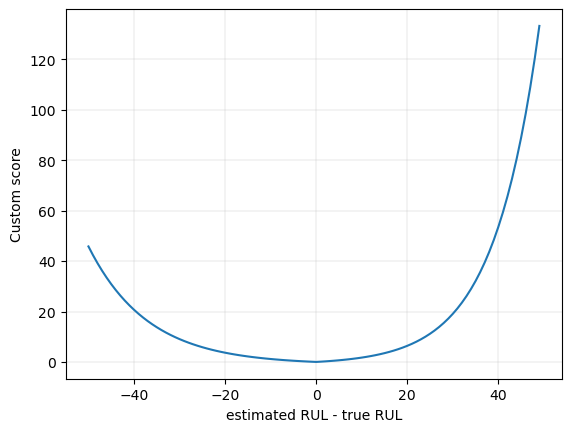

In [24]:
def rul_score_f(err):
    if err >= 0:
        return np.exp(err / 10) - 1
    else:
        return np.exp(- err / 13) - 1


# Why this metric is a sum? Why not average?
# it means the metric increases with the size of the dataset
# and it means that it's not comparable between datasets
# of different sizes
def rul_score(true_rul, estimated_rul):
    err = estimated_rul - true_rul
    return np.sum([rul_score_f(x) for x in err])

plt.plot(np.arange(-50, 50), 
         [rul_score_f(x) for x in np.arange(-50, 50)])
plt.xlabel('estimated RUL - true RUL')
plt.ylabel('Custom score')
plt.grid(linewidth=0.2)
plt.show()

# Our evaluation metrics in overall :

*All our model will be evaluated on that function*

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


def rul_metrics_scorer(model, X, true_rul, metrics='all'):
    '''
    Calculate evaluation metrics:
        1. rmse - Root Mean Squared Error
        2. mae - Mean Absolute Error
        3. mape - Mean Absolute Percentage Error
        4. score - Custom metric with higher weight on underestimated RUL

    Returns
    -------
    dict with metrics
    '''
    scores_f = {
        'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error,
        'mape': mean_absolute_percentage_error,
        'score': rul_score
    }

    pred_rul = model.predict(X)

    def calculate_scores(metrics_list):
        return {m: scores_f[m](true_rul, pred_rul) for m in metrics_list}

    if metrics == 'all':
        return calculate_scores(scores_f.keys())
    elif isinstance(metrics, list):
        return calculate_scores(metrics)

We will create a easy model to compare our models against, this is going to be the baseline without any prepocessing, just the raw data.

In [53]:
class PercentileBaselineModel:
    '''
    Estimate RUL based on a chosen percentile of longer-lived engines.
    '''
    def __init__(self, percentile=45):
        self.percentile = percentile

    def fit(self, X):
        self.lifetime = X.groupby('unit')['time_cycles'].max().reset_index(name='last_cycle')

    def predict(self, X):
        rul = []
        for current_cycle in X['time_cycles'].values:
            candidates = self.lifetime[self.lifetime['last_cycle'] > current_cycle]['last_cycle']
            if candidates.empty:
                estimated_rul = np.random.randint(1, 50)
            else:
                threshold = np.percentile(candidates, self.percentile)
                estimated_rul = round(threshold - current_cycle)
            rul.append(estimated_rul)
        return np.array(rul)


In [51]:
def plot_residuals_vs_actual(actual_rul, predicted_rul,
                             title='Test set - Residuals vs Actual RUL',
                             xlabel='Actual RUL', ylabel='Residuals',
                             ax=None):
    '''A scatter plot of residuals vs '''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    residual = predicted_rul - actual_rul
    ax.set_title(title)
    sns.regplot(x=actual_rul, y=residual, lowess=True, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.grid()


In [54]:
baseline_model = PercentileBaselineModel()
baseline_model.fit(train_data)

Baseline result ; 

In [55]:
test_last_cycles = test_data.groupby('unit', as_index=False)['time_cycles'].max()
rul_metrics_scorer(baseline_model, test_last_cycles, test_rul)

{'rmse': 35.94579252151773,
 'mae': 28.44,
 'mape': 0.6301371692972046,
 'score': 7850.591061560486}

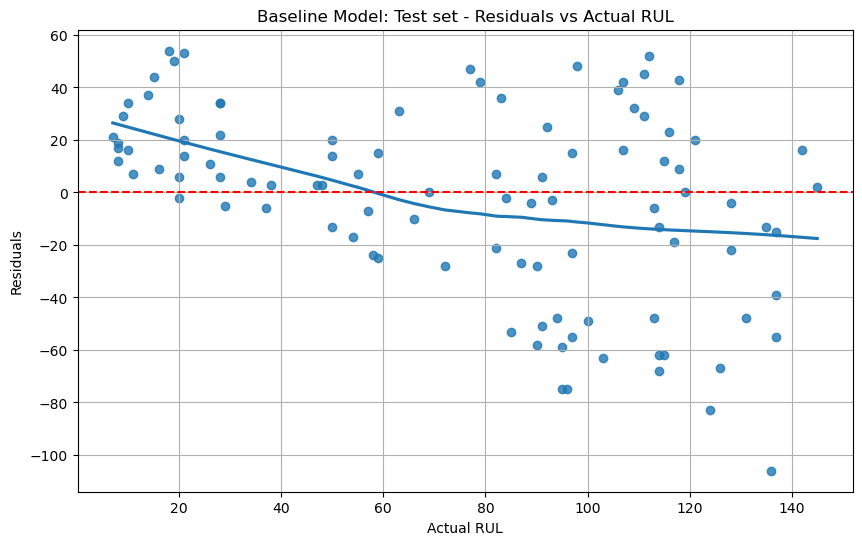

In [56]:
test_pred = baseline_model.predict(test_last_cycles)

plot_residuals_vs_actual(test_rul, test_pred,title='Baseline Model: Test set - Residuals vs Actual RUL')

---